In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import accuracy_score
import time
from IPython.display import HTML
import json
from sklearn.preprocessing import LabelEncoder

import torch.utils.data
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit

In [2]:
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
def create_data(X, y):  
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
    return X_train, X_valid, y_train, y_valid  

def create_datasets(X1, X2, X3, X4, X5, X6, X7, X8, X9, y):
    X1 = torch.tensor(X1, dtype=torch.float32) 
    X2 = torch.tensor(X2, dtype=torch.float32) 
    X3 = torch.tensor(X3, dtype=torch.float32) 
    X4 = torch.tensor(X4, dtype=torch.float32) 
    X5 = torch.tensor(X5, dtype=torch.float32) 
    X6 = torch.tensor(X6, dtype=torch.float32)     
    X7 = torch.tensor(X7, dtype=torch.float32) 
    X8 = torch.tensor(X8, dtype=torch.float32) 
    X9 = torch.tensor(X9, dtype=torch.float32)     
    
    y = torch.tensor(y, dtype=torch.long)
    data_ds = TensorDataset(X1, X2, X3, X4, X5, X6, X7, X8, X9, y)
    return data_ds

def create_dataloaders(train_ds, valid_ds, bs=128):
    train_dl = DataLoader(train_ds, bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False)
    return train_dl, valid_dl  

def test_dataloaders(test_ds, bs=128):
    test_dl = DataLoader(valid_ds, bs, shuffle=False)
    return test_dl  

In [4]:
class Net_1DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 100, 100, 60)   
        self.conv2 = nn.Conv1d(100, 100, 10, 1) 
        self.mp = nn.MaxPool1d(2)
        self.fc = nn.Sequential(nn.Linear(100*45,100), nn.ReLU())
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.mp(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x
    


In [5]:
class MyEnsemble(nn.Module):
    def __init__(self, Net_1DCNN, output_dim):
        super(MyEnsemble, self).__init__()        
        self.cnn = Net_1DCNN
        self.fc = nn.Sequential(nn.Linear(900,100), nn.ReLU())
        self.classifier = nn.Sequential(nn.Linear(100, output_dim), nn.Softmax(dim=1))
        
    def forward(self, x1, x2, x3, x4, x5, x6, x7, x8, x9):
        x1 = self.cnn(x1)
        x2 = self.cnn(x2)
        x3 = self.cnn(x3)
        x4 = self.cnn(x4)
        x5 = self.cnn(x5)
        x6 = self.cnn(x6)
        x7 = self.cnn(x7)
        x8 = self.cnn(x8)
        x9 = self.cnn(x9)        
        x = torch.cat((x1, x2, x3, x4, x5, x6, x7, x8, x9), dim=1)
        x = self.fc(x)
        x = self.classifier(x)
        return x

In [6]:
def rms(y):
    return np.sqrt(np.mean(y**2))    

**DATA PREPARATION**
---

In [7]:
work = []
signal = []
list_file = ['time_serie_1.p', 'time_serie_2.p', 'time_serie_3.p', 'time_serie_4.p', 'time_serie_5.p', 'time_serie_6.p']

for file in list_file:
  with open(file,'rb') as f:
        while True:
          try:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1' 
            p = u.load()      
            A = p['acc']
            signal.append(A)
            work.append(p['jobname'])

          except EOFError:
            break            


In [8]:
df = pd.read_csv('compare_single.csv')
s = df['label_s'].to_list()
job = df['jobname'].to_list()

label = {}
for i in range(len(job)):
#     lab = -1
#     if s[i] == 0:
#         lab = s[i]
#     if s[i] == 3:
#         lab = s[i]
        
#     label[int(job[i])] = int(lab)
    label[int(job[i])] = s[i]


In [9]:
y = []
for i in range(len(work)):
    y.append(label[int(work[i])])

y = np.array(y)    


In [10]:
signal = np.array(signal)[:,:6000,:]
signal0=signal
list_id = np.where(y!=-1)

signal0 = signal0[list_id]
y = y[list_id]


In [11]:
le = LabelEncoder()
le.fit(np.unique(y))
y = le.transform(y)

In [12]:
Xmax = np.max(signal0)
Xmin = np.min(signal0)
signal0 = (signal0 - Xmin) / (Xmax-Xmin)

In [13]:
v_rms= rms(signal0)

In [14]:
signal1 = signal0 + 0.001*v_rms*np.random.normal(0.0, 1.0, np.shape(signal0))
signal2 = signal0 + 0.001*v_rms*np.random.normal(0.0, 1.0, np.shape(signal0))
signal3 = signal0 + 0.001*v_rms*np.random.normal(0.0, 1.0, np.shape(signal0))
# signal4 = signal0 + 0.001*v_rms*np.random.normal(0.0, 1.0, np.shape(signal0))
# signal5 = signal0 + 0.001*v_rms*np.random.normal(0.0, 1.0, np.shape(signal0))

In [15]:
yy = np.concatenate((y,y,y,y),axis=0)
# yy = y

In [16]:
X = np.concatenate((signal0, signal1, signal2, signal3),axis=0)
# X = signal0

In [17]:
# import sys

# # These are the usual ipython objects, including this one you are creating
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# sorted([(x, int(sys.getsizeof(globals().get(x))/1024**3)) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [18]:
print(np.shape(X), np.shape(yy))

(12296, 6000, 9) (12296,)


In [19]:
X_trv, X_test, y_trv, y_test = create_data(X, yy)
X_train, X_valid, y_train, y_valid = create_data(X_trv, y_trv)

X1_train = X_train[:,:,0] 
X2_train = X_train[:,:,1] 
X3_train = X_train[:,:,2] 
X4_train = X_train[:,:,3] 
X5_train = X_train[:,:,4] 
X6_train = X_train[:,:,5] 
X7_train = X_train[:,:,6] 
X8_train = X_train[:,:,7] 
X9_train = X_train[:,:,8] 

X1_valid = X_valid[:,:,0] 
X2_valid = X_valid[:,:,1] 
X3_valid = X_valid[:,:,2] 
X4_valid = X_valid[:,:,3] 
X5_valid = X_valid[:,:,4] 
X6_valid = X_valid[:,:,5] 
X7_valid = X_valid[:,:,6] 
X8_valid = X_valid[:,:,7] 
X9_valid = X_valid[:,:,8] 

X1_test = X_test[:,:,0] 
X2_test = X_test[:,:,1] 
X3_test = X_test[:,:,2] 
X4_test = X_test[:,:,3] 
X5_test = X_test[:,:,4] 
X6_test = X_test[:,:,5] 
X7_test = X_test[:,:,6] 
X8_test = X_test[:,:,7] 
X9_test = X_test[:,:,8] 

X1_train =X1_train.reshape(X1_train.shape[0], -1, 1)
X2_train =X2_train.reshape(X2_train.shape[0], -1, 1)
X3_train =X3_train.reshape(X3_train.shape[0], -1, 1)
X4_train =X4_train.reshape(X4_train.shape[0], -1, 1)
X5_train =X5_train.reshape(X5_train.shape[0], -1, 1)
X6_train =X6_train.reshape(X6_train.shape[0], -1, 1)
X7_train =X7_train.reshape(X7_train.shape[0], -1, 1)
X8_train =X8_train.reshape(X8_train.shape[0], -1, 1)
X9_train =X9_train.reshape(X9_train.shape[0], -1, 1)

X1_valid =X1_valid.reshape(X1_valid.shape[0], -1, 1)
X2_valid =X2_valid.reshape(X2_valid.shape[0], -1, 1)
X3_valid =X3_valid.reshape(X3_valid.shape[0], -1, 1)
X4_valid =X4_valid.reshape(X4_valid.shape[0], -1, 1)
X5_valid =X5_valid.reshape(X5_valid.shape[0], -1, 1)
X6_valid =X6_valid.reshape(X6_valid.shape[0], -1, 1)
X7_valid =X7_valid.reshape(X7_valid.shape[0], -1, 1)
X8_valid =X8_valid.reshape(X8_valid.shape[0], -1, 1)
X9_valid =X9_valid.reshape(X9_valid.shape[0], -1, 1)


X1_test =X1_test.reshape(X1_test.shape[0], -1, 1)
X2_test =X2_test.reshape(X2_test.shape[0], -1, 1)
X3_test =X3_test.reshape(X3_test.shape[0], -1, 1)
X4_test =X4_test.reshape(X4_test.shape[0], -1, 1)
X5_test =X5_test.reshape(X5_test.shape[0], -1, 1)
X6_test =X6_test.reshape(X6_test.shape[0], -1, 1)
X7_test =X7_test.reshape(X7_test.shape[0], -1, 1)
X8_test =X8_test.reshape(X8_test.shape[0], -1, 1)
X9_test =X9_test.reshape(X9_test.shape[0], -1, 1)



train_ds = create_datasets(X1_train, X2_train, X3_train, X4_train, X5_train, X6_train, X7_train, X8_train, X9_train, y_train)
valid_ds = create_datasets(X1_valid, X2_valid, X3_valid, X4_valid, X5_valid, X6_valid, X7_valid, X8_valid, X9_valid, y_valid)
test_ds = create_datasets(X1_test, X2_test, X3_test, X4_test, X5_test, X6_test, X7_test, X8_test, X9_test, y_test)
train_dl, valid_dl = create_dataloaders(train_ds, valid_ds)
test_dl = test_dataloaders(test_ds, bs=len(y_test))

In [26]:
step_dim = np.shape(X)[1]
output_dim = len(np.unique(yy))

cnn1D = Net_1DCNN()
model = MyEnsemble(cnn1D, output_dim)
model = model.cuda()

lr = 0.0001
n_epochs = 300
best_acc = 0

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss = []
valid_acc = []
start = timeit.default_timer()

for epoch in range(1, n_epochs + 1):   
    for i, (x1_train, x2_train, x3_train, x4_train, x5_train, x6_train, x7_train, x8_train, x9_train, y_train) in enumerate(train_dl):
        model.train()
        x1_train, x2_train, x3_train, x4_train, x5_train, x6_train, x7_train, x8_train, x9_train, y_train = [t.cuda() for t in (x1_train, x2_train, x3_train, x4_train, x5_train, x6_train, x7_train, x8_train, x9_train, y_train)]
        optimizer.zero_grad()
        output = model(x1_train, x2_train, x3_train, x4_train, x5_train, x6_train, x7_train, x8_train, x9_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
    
    if epoch % 3 == 0:
        model.eval()        
        Ncorrect, Nsample = 0, 0
        for x1_val, x2_val, x3_val, x4_val, x5_val, x6_val, x7_val, x8_val, x9_val, y_val in valid_dl:
            x1_val, x2_val, x3_val, x4_val, x5_val, x6_val, x7_val, x8_val, x9_val, y_val = [t.cuda() for t in (x1_val, x2_val, x3_val, x4_val, x5_val, x6_val, x7_val, x8_val, x9_val, y_val)]
            out = model(x1_val, x2_val, x3_val, x4_val, x5_val, x6_val, x7_val, x8_val, x9_val)
            preds = F.log_softmax(out, dim=1).argmax(dim=1)
            Nsample += y_val.size(0)
            Ncorrect += (preds == y_val).sum().item()

        acc = Ncorrect / Nsample   
        valid_acc.append(acc)
        train_loss.append(loss.item())        
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

#     if acc > best_acc:
#         best_acc = acc
#         torch.save(model.state_dict(), 'best.pth')
#         print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')

stop = timeit.default_timer()
print('Time: ', stop - start)  

Epoch:   3. Loss: 1.3867. Acc.: 25.65%
Epoch:   6. Loss: 1.2822. Acc.: 43.27%
Epoch:   9. Loss: 1.2475. Acc.: 48.96%
Epoch:  12. Loss: 1.2021. Acc.: 57.00%
Epoch:  15. Loss: 1.1631. Acc.: 58.81%
Epoch:  18. Loss: 1.0718. Acc.: 61.97%
Epoch:  21. Loss: 1.0362. Acc.: 65.13%
Epoch:  24. Loss: 1.0133. Acc.: 68.29%
Epoch:  27. Loss: 1.0836. Acc.: 69.74%
Epoch:  30. Loss: 0.9675. Acc.: 72.09%
Epoch:  33. Loss: 1.0143. Acc.: 71.73%
Epoch:  36. Loss: 0.9640. Acc.: 73.17%
Epoch:  39. Loss: 0.9663. Acc.: 73.89%
Epoch:  42. Loss: 0.9583. Acc.: 74.71%
Epoch:  45. Loss: 0.9854. Acc.: 75.07%
Epoch:  48. Loss: 1.0432. Acc.: 76.33%
Epoch:  51. Loss: 1.0131. Acc.: 77.60%
Epoch:  54. Loss: 0.9120. Acc.: 79.04%
Epoch:  57. Loss: 0.8807. Acc.: 79.86%
Epoch:  60. Loss: 0.9719. Acc.: 79.58%
Epoch:  63. Loss: 0.8897. Acc.: 80.49%
Epoch:  66. Loss: 0.9241. Acc.: 80.85%
Epoch:  69. Loss: 0.9188. Acc.: 81.75%
Epoch:  72. Loss: 0.8850. Acc.: 82.02%
Epoch:  75. Loss: 0.8756. Acc.: 82.20%
Epoch:  78. Loss: 0.9063.

In [1]:
1189/300

3.9633333333333334

**VISUALIZATION**
---

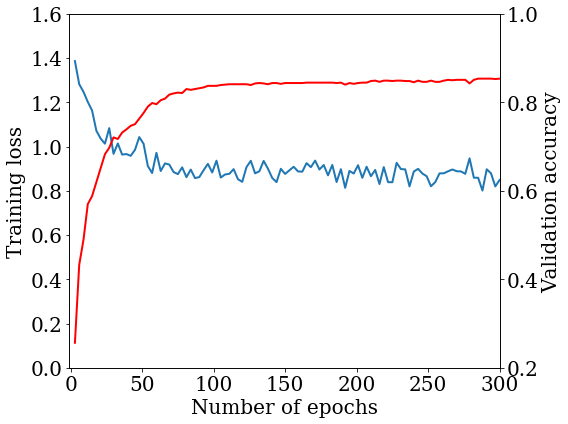

In [38]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.use('Agg')
# %matplotlib inline
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
rcParams.update({'font.size': 10})

fig, ax1 = plt.subplots(figsize=(8,6))
fsize = 20

ax2 = ax1.twinx()
nepo = (np.arange(len(valid_acc))+1)*3

id = np.arange(len(nepo))
id = id[id!=50]
train_loss = np.array(train_loss)
valid_acc = np.array(valid_acc)

ax1.plot(nepo[id], train_loss[id], linewidth=2.0)
ax2.plot(nepo[id], valid_acc[id],'r', linewidth=2.0)

ax1.set_xlabel('Number of epochs', fontsize=fsize)
ax1.set_ylabel('Training loss', fontsize=fsize)
ax2.set_ylabel('Validation accuracy', fontsize=fsize)


ax1.set_xlim(-1, 300)
ax1.set_ylim(0.0, 1.6)
ax2.set_ylim(0.2, 1.0)
# ax1.axvline(x=0, color='k')
# ax2.axvline(x=300, color='k')

# ax2.axhline(y=0.2, color='k')
# ax1.axhline(y=1.598, color='k')
ax1.xaxis.tick_bottom()


# Set the tick labels font
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(fsize)

# ax1.set_yticks([0.7, 0.9, 1.1, 1.3, 1.5])    
ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])   
    
# Hide grid lines
ax1.grid(False)        
ax2.grid(False)        
plt.tight_layout()
# ax1.legend(['Train_loss', 'Val_acc'], loc='upper right')

plt.show()
plt.savefig('1DCNN_severity_Loss.png', transparent=True)



In [32]:
valid_acc[50]

[0.7940379403794038,
 0.8437217705510388,
 0.8437217705510388,
 0.8437217705510388,
 0.8446251129177959,
 0.8446251129177959,
 0.8446251129177959,
 0.8446251129177959,
 0.8446251129177959,
 0.8446251129177959]

In [40]:
nb_classes = output_dim

confusion_matrix = torch.zeros(nb_classes, nb_classes)

test_dl = test_dataloaders(test_ds)
y_pred = []
y_actual = []
with torch.no_grad():
    for x1_test, x2_test, x3_test, x4_test, x5_test, x6_test, x7_test, x8_test, x9_test, y0_test in test_dl:
        x1_test, x2_test, x3_test, x4_test, x5_test, x6_test, x7_test, x8_test, x9_test, y0_test = [t.cuda() for t in (x1_test, x2_test, x3_test, x4_test, x5_test, x6_test, x7_test, x8_test, x9_test, y0_test)]
        out = model(x1_test, x2_test, x3_test, x4_test, x5_test, x6_test, x7_test, x8_test, x9_test)
        _, preds = torch.max(out, 1)
        y_pred += preds.view(-1).tolist()
        y_actual += y0_test.view(-1).tolist()
        for t, p in zip(y0_test.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[272.,   3.,   1.,   1.],
        [ 29., 236.,  10.,  17.],
        [ 23.,  36., 206.,  19.],
        [  2.,  16.,   5., 231.]])


              precision    recall  f1-score   support

           0       0.83      0.98      0.90       277
           1       0.81      0.81      0.81       292
           2       0.93      0.73      0.81       284
           3       0.86      0.91      0.89       254

    accuracy                           0.85      1107
   macro avg       0.86      0.86      0.85      1107
weighted avg       0.86      0.85      0.85      1107



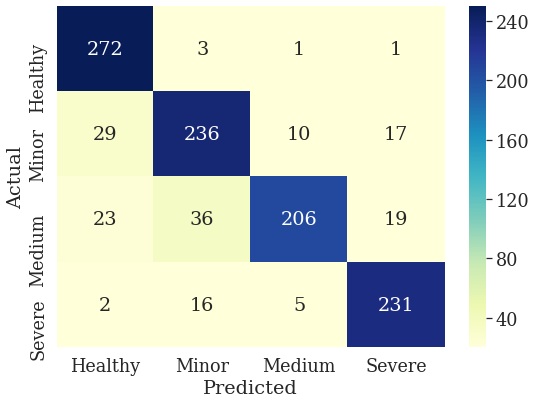

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_actual, y_pred))
cm =confusion_matrix(y_actual, y_pred)  

# index = np.arange(0,output_dim)
# columns = np.arange(0,output_dim)
index = ['Healthy', 'Minor', 'Medium', 'Severe']
columns = ['Healthy', 'Minor', 'Medium', 'Severe']


cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(8,6))  
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
sns.set(font_scale=1.6)
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
g= sns.heatmap(cm_df, annot=True, cmap= "YlGnBu", fmt='g', vmin=20, vmax=250)

g.set(ylim=(len(cm_df), 0))

plt.tight_layout()
plt.savefig('1DCNN_severity.png')

In [ ]:
plt.hist(yy)